In [163]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [164]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [165]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [166]:
# build the dataset
BLOCK_SIZE = 3 # context length: how many characters do we take to predict the next one?
ALPHABET_SIZE = 27
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [167]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 10 # the dimensionality of the character embedding vectors
HIDDEN_SIZE = 64 # the number of neurons in the hidden layer of the MLP

In [168]:
class Embedding:
    def __init__(self, n, size):
        self.embedding_table = torch.randn((n, size), generator=g)
    
    def __call__(self, x):
        self.out = self.embedding_table[x]
        return self.out
    
    def parameters(self):
        return [self.embedding_table]

In [169]:
class Flatten:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        self.out = x.view(-1, self.n)
        return self.out
    
    def parameters(self):
        return []

In [170]:
class Linear:
    def __init__(self, n_input, n_output, bias=True):
        self.W = torch.randn((n_input, n_output), generator=g) * (5/3) / (n_input ** 0.5)
        self.b = torch.randn(n_output, generator=g) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        params = [self.W]
        if self.b is not None:
            params.append(self.b)
        return params

In [171]:
class BatchNorm1D:
    def __init__(self, n_hidden):
        self.gain = torch.ones((1, n_hidden))
        self.bias = torch.zeros((1, n_hidden))
        self.running_mean = torch.zeros((1, n_hidden))
        self.running_stddev = torch.ones((1, n_hidden))
        self.training = True

    def __call__(self, x: torch.Tensor):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True)
        else:
            mean = self.running_mean
            std = self.running_stddev

        self.out = self.gain * (x - mean) / std + self.bias

        if self.training:
            self.running_mean = self.running_mean * 0.9 + mean * 0.1
            self.running_stddev = self.running_stddev * 0.9 + std * 0.1
        return self.out

    def parameters(self):
        return [self.gain, self.bias]


In [172]:
class Tanh: 
    def __call__(self, x: torch.Tensor):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []

In [173]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [174]:
EMBEDDING_SIZE = 20
model = Sequential([
    Embedding(ALPHABET_SIZE, EMBEDDING_SIZE), Flatten(BLOCK_SIZE * EMBEDDING_SIZE),
    Linear(BLOCK_SIZE*EMBEDDING_SIZE, HIDDEN_SIZE, bias=False), BatchNorm1D(HIDDEN_SIZE), Tanh(),
    Linear(HIDDEN_SIZE, ALPHABET_SIZE), 
])
for param in model.parameters():
    param.requires_grad = True

In [175]:
def step(X, Y, step_count):
    batch_size = 32
    idxs = torch.randint(0, X.shape[0], (batch_size,))
    X_batch = X[idxs]
    Y_batch = Y[idxs]

    out = model(X_batch)
    loss = F.cross_entropy(out, Y_batch)

    for param in model.parameters():
        param.grad = None

    loss.backward()

    learning_rate = 0.1 if step_count < 100_000 else 0.01
    for param in model.parameters():
        param.data += -learning_rate * param.grad
    
    return loss.item()

In [176]:
stepi = []
lossi = []

In [177]:
for i in range(10_000):
    stepi.append(len(stepi) + 1)
    loss = step(Xtr, Ytr, stepi[-1])
    if stepi[-1] % 100 == 0:
        print("step %d, loss %f" % (stepi[-1], loss))
    lossi.append(loss)

step 100, loss 2.927650
step 200, loss 2.526307
step 300, loss 2.205328
step 400, loss 2.535862
step 500, loss 2.642743
step 600, loss 2.302850
step 700, loss 2.380329
step 800, loss 2.868746
step 900, loss 2.110101
step 1000, loss 2.340232
step 1100, loss 2.565303
step 1200, loss 2.524686
step 1300, loss 2.095640
step 1400, loss 2.068536
step 1500, loss 2.409040
step 1600, loss 2.411297
step 1700, loss 2.302690
step 1800, loss 2.255939
step 1900, loss 2.550008
step 2000, loss 2.214543
step 2100, loss 2.339599
step 2200, loss 2.052906
step 2300, loss 2.285081
step 2400, loss 2.332678
step 2500, loss 2.750273
step 2600, loss 2.268506
step 2700, loss 2.235622
step 2800, loss 2.055779
step 2900, loss 2.286591
step 3000, loss 2.062268
step 3100, loss 2.241537
step 3200, loss 2.528629
step 3300, loss 2.164155
step 3400, loss 2.259699
step 3500, loss 2.306625
step 3600, loss 1.818144
step 3700, loss 2.295273
step 3800, loss 2.719460
step 3900, loss 1.949273
step 4000, loss 2.650078
step 4100

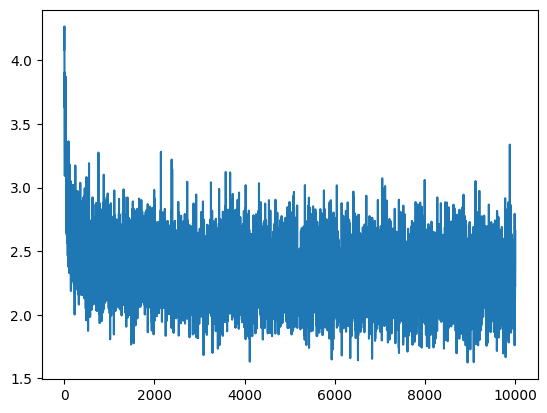

In [158]:
plt.plot(stepi, lossi)

In [159]:
# turn training off for BatchNorm layers before inference / loss calculation
for layer in model.layers:
    if isinstance(layer, BatchNorm1D):
        layer.training = False

In [160]:
def calculate_loss(X, Y):
    with torch.no_grad():
        out = model(X)
        loss = F.cross_entropy(out, Y)
        print(loss.item())        

In [161]:
calculate_loss(Xtr, Ytr)
calculate_loss(Xdev, Ydev)
calculate_loss(Xte, Yte)

2.236313581466675
2.24267840385437
2.2439305782318115


In [178]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

Embedding torch.Size([32, 3, 20])
Flatten torch.Size([32, 60])
Linear torch.Size([32, 64])
BatchNorm1D torch.Size([32, 64])
Tanh torch.Size([32, 64])
Linear torch.Size([32, 27])
